In [2]:
import pandas as pd
import pypsa
import yaml
from pathlib import Path

n = pypsa.Network(Path.cwd().parent / "resources" / "networks" / "base.nc")

INFO:pypsa.io:Imported network base.nc has buses, carriers, lines, links, transformers


(<matplotlib.collections.PatchCollection at 0x2228ecf8100>,
 <matplotlib.collections.LineCollection at 0x2228ef10730>)

c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


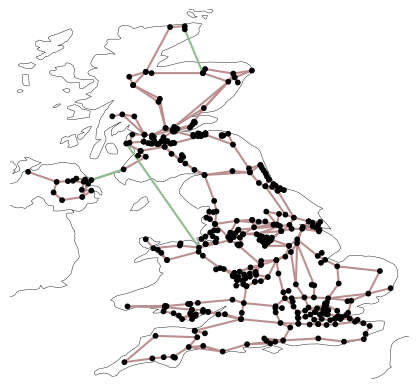

In [22]:
import matplotlib.pyplot as plt

# plt.scatter(n.buses.x, n.buses.y, s=10)

n.plot(bus_alpha=1, bus_sizes=0.005, bus_colors='k')

In [9]:
import geopandas as gpd
import pandas as pd

regions = gpd.read_file(Path.cwd().parent / "data" / "eso_zonal_shapes.geojson").set_index("name")
regions = regions.loc[regions.index.str.contains("GB")]

<AxesSubplot:>

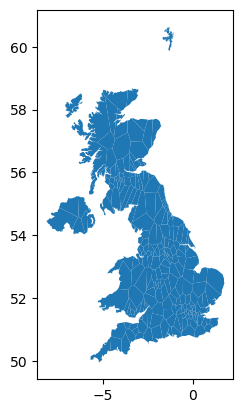

In [28]:
busregions = gpd.read_file(Path.cwd().parent / "resources" / "regions_onshore.geojson")
offshore = gpd.read_file(Path.cwd().parent / "resources" / "regions_offshore.geojson")
busregions.plot()

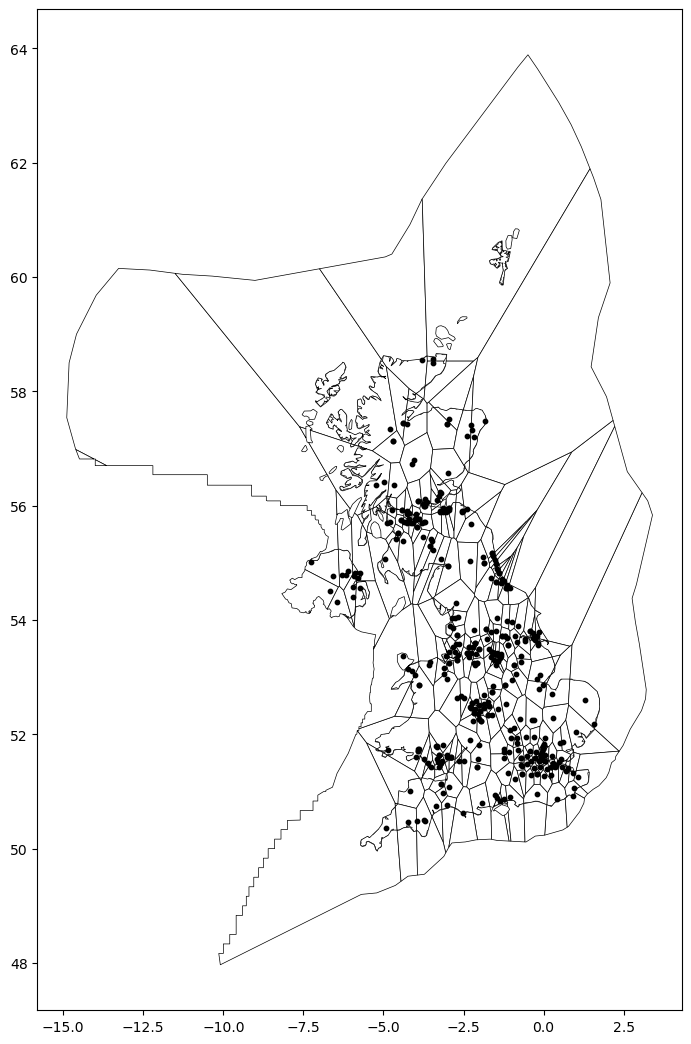

In [45]:
fig, ax = plt.subplots(figsize=(13, 13))

busregions.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
offshore.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
ax.scatter(n.buses.x, n.buses.y, s=10, c='k')

gpd.GeoDataFrame(n.buses, geometry=gpd.points_from_xy(n.buses.x, n.buses.y)).to_file("buses.geojson", driver="GeoJSON")


plt.show()

#### Data from WIKI

In [75]:
from SPARQLWrapper import SPARQLWrapper, JSON
import geopandas as gpd

# Define the SPARQL endpoint URL
sparql_url = "https://query.wikidata.org/sparql"

# Create a SPARQLWrapper object with the defined URL
sparql = SPARQLWrapper(sparql_url)

# Define your SPARQL query
sparql_query = """
SELECT DISTINCT ?item ?itemLabel ?bmrs_id ?repd_id ?lat ?lon ?capacity ?typeLabel WHERE {
  ?item wdt:P11610 ?bmrs_id.
  OPTIONAL { ?item wdt:P9891 ?repd_id. }
  OPTIONAL { ?item wdt:P2109 ?capacity. }
  OPTIONAL {
    ?item p:P625 ?point .
    ?point psv:P625 ?point_value .
    ?point_value wikibase:geoLatitude ?lat.
    ?point_value wikibase:geoLongitude ?lon.
  }
  OPTIONAL {
    ?item wdt:P31 ?type.
    ?type wdt:P279+ wd:Q159719.
  }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
"""

# Set the query to the SPARQLWrapper object
sparql.setQuery(sparql_query)

# Set the return format to JSON (SPARQLWrapper supports XML, JSON, and others)
sparql.setReturnFormat(JSON)

# Execute the query and convert the result to a Python dictionary
results = sparql.query().convert()

lats = [float(result.get("lat", {"value": "0"})["value"]) for result in results["results"]["bindings"]]
lons = [float(result.get("lon", {"value": "0"})["value"]) for result in results["results"]["bindings"]]
bmids = [result.get("bmrs_id", {"value": "0"})["value"] for result in results["results"]["bindings"]]
repdid = [result.get("repd_id", {"value": "0"})["value"] for result in results["results"]["bindings"]]
cap = [float(result.get("capacity", {"value": "0"})["value"]) for result in results["results"]["bindings"]]
item = [result.get("item", {"value": "0"})["value"] for result in results["results"]["bindings"]]
itemlabel = [result.get("itemLabel", {"value": "0"})["value"] for result in results["results"]["bindings"]]
typelabel = [result.get("typeLabel", {"value": "0"})["value"] for result in results["results"]["bindings"]]

wiki = pd.DataFrame({
    "lat": lats,
    "lon": lons,
    "bmrs_id": bmids,
    "repd_id": repdid,
    "capacity": cap,
    "item": item,
    "itemlabel": itemlabel,
    "type": typelabel
    })

#### From OSM

In [95]:
import geopandas as gpd
import pandas as pdd
import numpy as np
import matplotlib.pyplot as plt

osm = gpd.read_file("export.geojson")

In [100]:
osm.shape

(9423, 176)

In [108]:
numvals = pd.Series()
for col in osm.columns:
    # print(col, osm[col].nunique())
    numvals.loc[col] = osm[col].nunique()

# osm["plant"].value_counts()

numvals.loc[numvals > 2].sort_values(ascending=False)

geometry                        9421
@id                             9420
id                              9420
repd:id                         1528
name                            1411
@relations                       903
operator                         562
plant:output:electricity         296
wikidata                         105
start_date                        92
source                            64
note                              61
website                           56
wikipedia                         33
addr:street                       32
addr:postcode                     32
owner                             28
addr:city                         27
alt_name                          23
generator:output:electricity      23
operator:wikidata                 20
plant:storage                     19
plant:source                      19
fixme                             18
turbines                          15
postal_code                       14
ref                               11
p

In [110]:
osm.geometry.apply(lambda geom: geom.geom_type).value_counts()

geometry
Point           6669
Polygon         1320
LineString      1266
MultiPolygon     168
Name: count, dtype: int64

(1474,)
(1463,)
188     3960.00
237     3267.00
374     1610.00
157     1400.00
4       1250.00
         ...   
1463       0.60
905        0.50
1257       0.40
1159       0.40
1466       0.18
Name: plant:output:electricity, Length: 1463, dtype: float64
39786.465


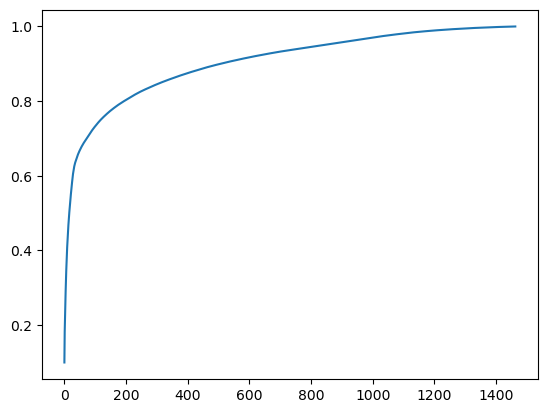

In [143]:
o = osm["plant:output:electricity"].dropna()
print(o.shape)
o = o.loc[o != 'yes']
print(o.shape)
o = o.str[:-3].astype(float)



"""
(
    (o := )
    .loc[o != '']
    .str[:-3]
    .astype(float)
)
"""
print(o.sort_values(ascending=False))
total = o.sum()

plt.plot(range(len(o)), o.sort_values(ascending=False).cumsum() / total)
print(o.sum())

first_x = 500
idx = o.sort_values(ascending=False).index[:first_x]

In [145]:
osm["location"].fillna("none").value_counts()[:30]

osm.loc[:, "geom_type"] = osm.geometry.apply(lambda geom: geom.geom_type)

In [148]:
osm.loc[idx, ["geom_type", "@id", "id", "repd:id", "name", ]]

,geom_type,@id,id,repd:id,name,turbines
188,Polygon,way/34383063,way/34383063,6659;192;175;174,Drax Power Station,None
237,Polygon,way/202996492,way/202996492,1341,Willsland Solar Farm,None
374,Polygon,way/432471621,way/432471621,1,Aberthaw 'B' Power Station,None
157,Polygon,relation/11343101,relation/11343101,2502,Hornsea 2 Offshore Wind Farm,None
4,MultiPolygon,relation/4603573,relation/4603573,1042,Westcott solar farm,None
...,...,...,...,...,...,...
477,Polygon,way/550883520,way/550883520,1349,Halse Solar Farm,None
165,MultiPolygon,relation/12333123,relation/12333123,1963,Berwick Solar Farm,None
869,Polygon,way/720373095,way/720373095,5169,Sheriffhales Solar Farm,None
68,MultiPolygon,relation/9456023,relation/9456023,2208,Nowhere Farm,None


In [146]:
import seaborn as sns

sns.regplot(osm.loc[idx, ["geom_type", "operator"]])

ValueError: need at least one array to concatenate

In [103]:
from pprint import pprint

for i in range(18):
    pprint(osm.columns[10*i:10*(i+1)])
    print('--=---------------')

Index(['id', '@id', 'abandoned:power', 'access', 'addr:city', 'addr:country',
       'addr:county', 'addr:housename', 'addr:housenumber', 'addr:locality'],
      dtype='object')
--=---------------
Index(['addr:place', 'addr:postcode', 'addr:street', 'addr:suburb',
       'addr:village', 'alt_name', 'amenity', 'area', 'barrier', 'boundary'],
      dtype='object')
--=---------------
Index(['building', 'building:levels', 'colour', 'construction',
       'construction:power', 'contact:phone', 'contact:website', 'description',
       'disused:landuse', 'disused:plant:source'],
      dtype='object')
--=---------------
Index(['disused:power', 'email', 'end_date', 'farmland', 'fax', 'fence',
       'fence:colour', 'fence:material', 'fence_type', 'fixme'],
      dtype='object')
--=---------------
Index(['floating', 'frequency', 'generator:manufacturer', 'generator:method',
       'generator:orientation', 'generator:output:electricity',
       'generator:output:hot_water', 'generator:place',
   

#### Using ELEXON Insights

In [67]:
import requests
import pandas as pd

from io import StringIO
from copy import deepcopy
from itertools import product

# Define the base URL of the API endpoint
url = 'https://data.elexon.co.uk/bmrs/api/v1/balancing/physical/all'

In [68]:
global query_params

query_params = {
    'dataset': 'PN',  # Dataset to query
    'settlementDate': "2023-01-01",  # Settlement date in yyyy-MM-dd format
    'settlementPeriod': 1,  # Settlement period, an integer from 1-48
    # 'bmUnit': ['2__HFLEX001', 'HUMR-1'],  # BM Units to query
    'format': 'csv'  # Response data format
}


def get_bm_data(date, period):

    if not isinstance(date, str):
        date = date.strftime("%Y-%m-%d")
    
    params = deepcopy(query_params)
    params.update({"settlementDate": date, "settlementPeriod": period})

    response = requests.get(url, params=params)
    return pd.read_csv(StringIO(response.text))


def process_multiples(df):
    """
    Units that were adjusted multiple times within a single settlement period
    are processed such that their entry is compressed into a single line.
    The 'LevelFrom' column is taken from the first entry, 'LevelTo' from the last 
    """
    
    new_rows = []

    for bmunit in (removals := (m := df["BmUnit"].value_counts()).loc[m > 1].index):
        
        new_row = (b := df.loc[df["BmUnit"] == bmunit]).iloc[-1].copy()
        new_row.loc["LevelFrom"] = b["LevelFrom"].iat[0]

        new_rows.append(new_row)
    
    df = df.loc[~df["BmUnit"].isin(removals)]

    return pd.concat([df, pd.concat(new_rows, axis=1).T], axis=0, ignore_index=True)


In [77]:
# dates = pd.date_range(start="2023-11-01", end="2024-02-14", freq="D")
dates = pd.date_range(start="2024-02-07", end="2024-02-14", freq="D")
periods = range(1, 49)
# params.update({"settlementPeriod": range(47, 51)})

dfs = []

for i, (date, period) in enumerate(product(dates, periods)):
    df = get_bm_data(date, period)
    
    df = process_multiples(df)
    df = (
        df
        .set_index(["SettlementDate", "SettlementPeriod", "NationalGridBmUnit"])
        [["LevelFrom", "LevelTo", "BmUnit"]]
    )

    dfs.append(df)

    if (i+1) % 10 == 0:
        
        print(f"Date: {date}, Period: {period}.")
        print(f"Saving for the {(i//10)+1}th time.")
        pd.concat(dfs, axis=0).to_csv("bm_data.csv")


df = pd.concat(dfs, axis=0)

Date: 2024-02-07 00:00:00, Period: 10.
Saving for the 0th time.
Date: 2024-02-07 00:00:00, Period: 20.
Saving for the 1th time.
Date: 2024-02-07 00:00:00, Period: 30.
Saving for the 2th time.
Date: 2024-02-07 00:00:00, Period: 40.
Saving for the 3th time.
Date: 2024-02-08 00:00:00, Period: 2.
Saving for the 4th time.
Date: 2024-02-08 00:00:00, Period: 12.
Saving for the 5th time.
Date: 2024-02-08 00:00:00, Period: 22.
Saving for the 6th time.
Date: 2024-02-08 00:00:00, Period: 32.
Saving for the 7th time.
Date: 2024-02-08 00:00:00, Period: 42.
Saving for the 8th time.
Date: 2024-02-09 00:00:00, Period: 4.
Saving for the 9th time.
Date: 2024-02-09 00:00:00, Period: 14.
Saving for the 10th time.
Date: 2024-02-09 00:00:00, Period: 24.
Saving for the 11th time.
Date: 2024-02-09 00:00:00, Period: 34.
Saving for the 12th time.
Date: 2024-02-09 00:00:00, Period: 44.
Saving for the 13th time.
Date: 2024-02-10 00:00:00, Period: 6.
Saving for the 14th time.
Date: 2024-02-10 00:00:00, Period: 16.

In [82]:
df.to_csv("last_week_bm.csv")

In [73]:
df.groupby()

LevelFrom LevelTo  \
SettlementDate SettlementPeriod NationalGridBmUnit                     
2023-11-01     44               BFSE02                     0       0   
                                BLKPB-1                    0       0   
                                GHAV01                     0       0   
                                HFSE01                     0       0   
                                IBD-EGEN1                  0       0   
...                                                      ...     ...   
               48               BEATO-2                   47      47   
                                CLDRW-1                   10      10   
                                ABRBO-1                   47      55   
                                FSDLW-1                    2       2   
                                EDINW-1                   10      10   

                                                       BmUnit  
SettlementDate SettlementPeriod NationalGridBmUnit             
2023-11-01     44               BFSE02                    NaN  
                                BLKPB-1                   NaN  
                                GHAV01                    NaN  
                                HFSE01                    NaN  
                                IBD-EGEN1                 NaN  
...                                                       ...  
               48               BEATO-2             T_BEATO-2  
                                CLDRW-1             E_CLDRW-1  
                                ABRBO-1             T_ABRBO-1  
                                FSDLW-1             T_FSDLW-1  
                                EDINW-1             T_EDINW-1  

[8931 rows x 3 columns]

In [59]:
df1["BmUnit"].value_counts()

df1.loc[df1["BmUnit"] == "E_PILLB-1"]


new_df = process_multiples(df1).copy()

In [63]:
new_df.set_index(["SettlementDate", "SettlementPeriod", "NationalGridBmUnit"])[["LevelFrom", "LevelTo", "BmUnit"]]

LevelFrom LevelTo  \
SettlementDate SettlementPeriod NationalGridBmUnit                     
2023-11-01     47               BFSE02                     0       0   
                                BLKPB-1                    0       0   
                                IIG-CAPT1                  0       0   
                                IIG-EGEN1                  0       0   
                                IMD-CAPT1                  0       0   
...                                                      ...     ...   
                                PNYCW-1                  207     210   
                                THNTO-1                  137     137   
                                THNTO-2                  137     137   
                                GORDW-2                    2       2   
                                GRIFW-1                   13      13   

                                                       BmUnit  
SettlementDate SettlementPeriod NationalGridBmUnit             
2023-11-01     47               BFSE02                    NaN  
                                BLKPB-1                   NaN  
                                IIG-CAPT1                 NaN  
                                IIG-EGEN1                 NaN  
                                IMD-CAPT1                 NaN  
...                                                       ...  
                                PNYCW-1             T_PNYCW-1  
                                THNTO-1             T_THNTO-1  
                                THNTO-2             T_THNTO-2  
                                GORDW-2             T_GORDW-2  
                                GRIFW-1             T_GRIFW-1  

[1785 rows x 3 columns]

In [61]:
new_df.loc[new_df["NationalGridBmUnit"].isna()]

,Dataset,SettlementDate,SettlementPeriod,TimeFrom,TimeTo,LevelFrom,LevelTo,NationalGridBmUnit,BmUnit


In [7]:
# str(pd.date_range("2023-01-18", "2023-01-20", freq="d")[0])[:10]

pd.date_range("2023-01-18", "2023-01-20", freq="d")[0].strftime("%Y-%m-%d")

'2023-01-18'

In [ ]:
r

# Make the GET request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Response was successful, print or process the content
    data = StringIO(response.text)
    ei_df = pd.read_csv(data)
else:
    # There was an error with the request
    print(f"Error: {response.status_code}")

In [2]:
# print(df["BmUnit"].value_counts())
# print(df.loc[df["BmUnit"] == "2__GLOND001"])
# print(len(df["BmUnit"].unique()))
print(ei_df.head())

  Dataset SettlementDate  SettlementPeriod              TimeFrom  \
0      PN     2023-01-18                 3  2023-01-18T01:29:00Z   
1      PN     2023-01-18                 3  2023-01-18T01:29:00Z   
2      PN     2023-01-18                 3  2023-01-18T01:29:00Z   
3      PN     2023-01-18                 3  2023-01-18T01:29:00Z   
4      PN     2023-01-18                 3  2023-01-18T01:29:00Z   

                 TimeTo  LevelFrom  LevelTo NationalGridBmUnit     BmUnit  
0  2023-01-18T01:30:00Z         10        0            BURWB-1  E_BURWB-1  
1  2023-01-18T01:30:00Z          1        0            POTES-1  E_POTES-1  
2  2023-01-18T01:30:00Z         51       44            BHLAW-1  T_BHLAW-1  
3  2023-01-18T01:30:00Z         99      101            CLDCW-1  T_CLDCW-1  
4  2023-01-18T01:30:00Z        103      100            CLDNW-1  T_CLDNW-1  


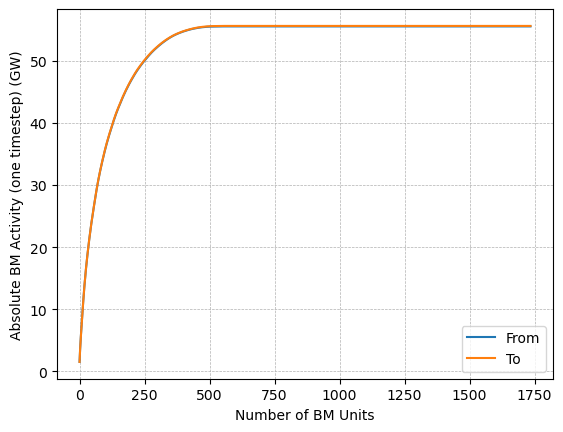

In [12]:
import matplotlib.pyplot as plt

plt.plot(
    ei_df.index,
    ei_df["LevelFrom"].abs().sort_values(ascending=False).cumsum().mul(1e-3).values,
    label="From",
)
plt.plot(
    ei_df.index,
    ei_df["LevelTo"].abs().sort_values(ascending=False).cumsum().mul(1e-3).values,
    label="To",
)

plt.xlabel("Number of BM Units")
plt.ylabel("Absolute BM Activity (one timestep) (GW)")
plt.grid(True, linestyle='dashed', linewidth=0.5)
plt.legend()

In [18]:
ei_df["abs"] = ei_df["LevelFrom"].abs()
print(ei_df.sort_values(by="abs", ascending=False).head())
print(ei_df.sort_values(by="abs", ascending=False).tail())

     Dataset SettlementDate  SettlementPeriod              TimeFrom  \
562       PN     2023-01-18                 3  2023-01-18T01:00:00Z   
1364      PN     2023-01-18                 3  2023-01-18T01:00:00Z   
1578      PN     2023-01-18                 3  2023-01-18T01:00:00Z   
201       PN     2023-01-18                 3  2023-01-18T01:00:00Z   
1570      PN     2023-01-18                 3  2023-01-18T01:00:00Z   

                    TimeTo  LevelFrom  LevelTo NationalGridBmUnit  \
562   2023-01-18T01:30:00Z      -1544    -1538          SSC-LON01   
1364  2023-01-18T01:30:00Z       1099     1099          ISG-NDPL1   
1578  2023-01-18T01:30:00Z        855      855             MRWD-1   
201   2023-01-18T01:30:00Z       -820     -779          LON-LON01   
1570  2023-01-18T01:30:00Z        710      710             MEDP-1   

           BmUnit   abs  
562   2__NLOND000  1544  
1364  I_ISG-NDPL1  1099  
1578     T_MRWD-1   855  
201   2__CLOND000   820  
1570     T_MEDP-1   710  
  

In [80]:
wiki.head(1)


,lat,lon,bmrs_id,repd_id,capacity,item,itemlabel,type
0,51.771111,1.992222,GAOFO-1,2526,353.0,http://www.wikidata.org/entity/Q56026054,Q56026054,Q1357601


In [94]:
wiki_within = wiki.loc[wiki["bmrs_id"].isin(ei_df["BmUnit"].str[2:])]
# within.sum()
wiki_within.head()

,lat,lon,bmrs_id,repd_id,capacity,item,itemlabel,type
2,56.276100,-4.062500,BRDUW-1,3119,72.0,http://www.wikidata.org/entity/Q614982,Q614982,Q194356
8,57.262111,-4.483528,FOYE-1,6842,300.0,http://www.wikidata.org/entity/Q11969812,Q11969812,Q339353
9,57.262111,-4.483528,FOYE-2,6842,300.0,http://www.wikidata.org/entity/Q11969812,Q11969812,Q339353
10,57.216700,-1.983330,ABRBO-1,2505,96.8,http://www.wikidata.org/entity/Q17509465,Q17509465,Q1357601
14,52.980800,-3.968890,FFES-3,6840,360.0,http://www.wikidata.org/entity/Q5446209,Q5446209,Q339353
